In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-LSTM/.ipynb_checkpoints/Multivariate-3-LSTM-Copy1-checkpoint.ipynb
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout
from sklearn.model_selection import KFold
from math import sqrt
import datetime as dt
plt.style.use('ggplot')

In [3]:
%cd '/content/drive/Shareddrives/myShareDrive'

/content/drive/Shareddrives/myShareDrive


In [4]:
#data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True)
data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True, index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
#data_APA = data.query('Ticker == "APA"').drop(['Unnamed: 0', 'Ticker'], axis=1)
data_APA = data.query('Ticker == "APA"').drop(['Ticker'], axis=1)

In [6]:
# Using set_index() method on 'Name' column
data_APA = data_APA.set_index(data_APA['Date'])

In [7]:
# Correlation matrix
data_APA.corr()['Close']

High         0.999711
Low          0.999743
Open         0.999399
Close        1.000000
Volume      -0.479447
Adj Close    0.999291
Name: Close, dtype: float64

In [ ]:
#data_APA = data_APA.drop(['Volume'], axis=1)

In [ ]:
#print(data_APA.describe().Volume) 

In [8]:
data_APA.drop(data_APA[data_APA['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

In [9]:
data_APA.shape

(2997, 7)

In [10]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [11]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs,loss,activation):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    # Adding LSTM layers and some Dropout regularisation
    for i in range(len(hl)-1):        
      model.add(LSTM(hl[i], activation = activation,return_sequences = True))
      #model.add(Dropout(0.2))
    model.add(LSTM(hl[-1],activation = activation))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [12]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [13]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [14]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [15]:
# Extracting the series
series = data_APA[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2997, 3)
                Close       High    Volume
Date                                      
2021-11-19  26.000000  27.010000  12427500
2021-11-22  26.530001  27.360001  11652900
2021-11-23  28.469999  28.500000  10602000
2021-11-24  28.610001  29.209999   8531600
2021-11-26  26.240000  26.549999   8469000


In [16]:
# Cross_Train_Val Test Split
cross_train_val_start = dt.date(2010,1,4)
cross_train_val_end = dt.date(2021,6,30)
cross_train_val_data = series.loc[cross_train_val_start:cross_train_val_end]

test_start = dt.date(2021,7,1)
test_end = dt.date(2021,12,31)
test_data = series.loc[test_start:test_end]

print(cross_train_val_data.shape,test_data.shape)

(2893, 3) (104, 3)


In [17]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

train = sc.fit_transform(cross_train_val_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(2893, 3) (104, 3)


In [18]:
timesteps = [50] 
hl = []
for i in range(40,50,10):
    hl.append([i,i-5])
lr = [1e-3]
batch_size = [64]
num_epochs = [50]
#optimizers = ['SGD', 'RMSprop', 'Adam']
loss = ['mean_squared_error']
activation = ['selu']

Epoch 1/50
36/36 [==============================] - 38s 819ms/step - loss: 0.0665 - val_loss: 0.4764
Epoch 2/50
36/36 [==============================] - 29s 811ms/step - loss: 0.0433 - val_loss: 0.2813
Epoch 3/50
36/36 [==============================] - 28s 790ms/step - loss: 0.0306 - val_loss: 0.1139
Epoch 4/50
36/36 [==============================] - 30s 841ms/step - loss: 0.0149 - val_loss: 0.0584
Epoch 5/50
36/36 [==============================] - 29s 804ms/step - loss: 0.0097 - val_loss: 0.0511
Epoch 6/50
36/36 [==============================] - 28s 782ms/step - loss: 0.0079 - val_loss: 0.0831
Epoch 7/50
36/36 [==============================] - 29s 797ms/step - loss: 0.0106 - val_loss: 0.0654
Epoch 8/50
36/36 [==============================] - 29s 804ms/step - loss: 0.0093 - val_loss: 0.0646
Epoch 9/50
36/36 [==============================] - 28s 772ms/step - loss: 0.0087 - val_loss: 0.0773
Epoch 10/50
36/36 [==============================] - 28s 776ms/step - loss: 0.0090 - val_lo

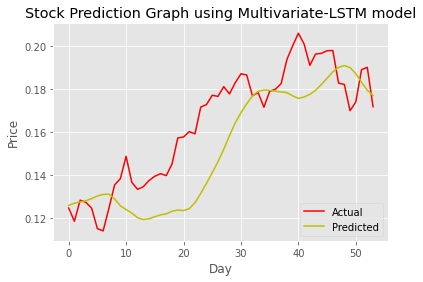

train_error  [0.06652465462684631, 0.04329919070005417, 0.030596857890486717, 0.014913609251379967, 0.009717089124023914, 0.007858368568122387, 0.010633623227477074, 0.009256702847778797, 0.008705166168510914, 0.008954881690442562, 0.007521861232817173, 0.006803795695304871, 0.007443503942340612, 0.006529275327920914, 0.0056131440214812756, 0.003951599821448326, 0.003594324691221118, 0.002639433601871133, 0.0029671858064830303, 0.0023728490341454744, 0.0022750552743673325, 0.002355921780690551, 0.0023492611944675446, 0.0027427885215729475, 0.0025113646406680346, 0.002584420144557953, 0.002509168116375804, 0.002673409879207611, 0.002340155653655529, 0.0025645948480814695, 0.002653681207448244, 0.00307252979837358, 0.0026213836390525103, 0.0036224371287971735, 0.0027412695344537497, 0.002739186165854335, 0.0029013522434979677, 0.0031535921152681112, 0.002743113785982132, 0.003386082360520959, 0.0030913089867681265, 0.0035079610534012318, 0.0034922307822853327, 0.003197724698111415, 0.003

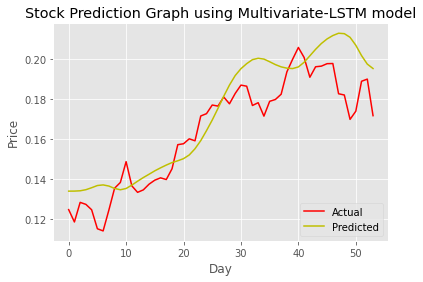

train_error  [0.060269784182310104, 0.05507463216781616, 0.036606233566999435, 0.01420366670936346, 0.02133318781852722, 0.010973908938467503, 0.010177068412303925, 0.011395836248993874, 0.007198471110314131, 0.007531989365816116, 0.007361842319369316, 0.007525426335632801, 0.005212677177041769, 0.0053122397512197495, 0.004349131602793932, 0.004626677371561527, 0.004188357852399349, 0.004013254772871733, 0.0047192759811878204, 0.005891764536499977, 0.0035732111427932978, 0.005486179608851671, 0.004783206153661013, 0.004525868222117424, 0.00527506647631526, 0.004456744529306889, 0.004466317128390074, 0.005122738890349865, 0.00520354975014925, 0.005149379838258028, 0.004858020693063736, 0.005412559024989605, 0.004156347829848528, 0.004813112318515778, 0.0037741984706372023, 0.004246347583830357, 0.0037170075811445713, 0.004200837109237909, 0.003189856419339776, 0.0041323378682136536, 0.0028523309156298637, 0.003693400416523218, 0.0033180261962115765, 0.0030668601393699646, 0.003161300439

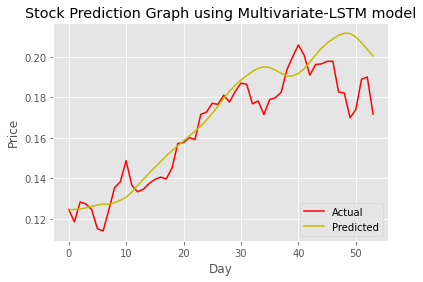

train_error  [0.07769452035427094, 0.0626150593161583, 0.04513774812221527, 0.04793176054954529, 0.0668075829744339, 0.028665384277701378, 0.020219052210450172, 0.036706261336803436, 0.0349736250936985, 0.02423129975795746, 0.020733583718538284, 0.0214858315885067, 0.012242354452610016, 0.0074738613329827785, 0.007498977705836296, 0.006747086066752672, 0.007735396269708872, 0.006217047572135925, 0.007417166605591774, 0.006712240166962147, 0.006060566753149033, 0.006237548775970936, 0.005480461288243532, 0.005898941773921251, 0.005318524315953255, 0.00533483549952507, 0.006440297234803438, 0.006139140110462904, 0.006297350395470858, 0.00578295299783349, 0.005063975229859352, 0.004684462212026119, 0.004487722180783749, 0.004326301626861095, 0.003979360684752464, 0.003753408556804061, 0.003400139743462205, 0.0031380229629576206, 0.002938578138127923, 0.003153627971187234, 0.0028761825524270535, 0.0027448113542050123, 0.0031668334268033504, 0.0026035087648779154, 0.0029480434022843838, 0.0

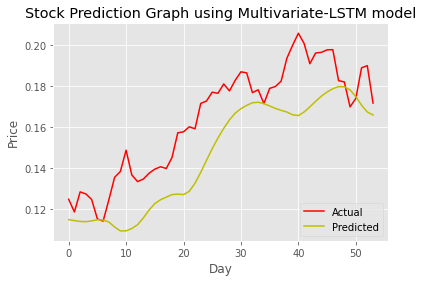

train_error  [0.040679797530174255, 0.04774080216884613, 0.044050946831703186, 0.032854579389095306, 0.028425490483641624, 0.025577854365110397, 0.022459665313363075, 0.01996624656021595, 0.018224431201815605, 0.016195762902498245, 0.013693331740796566, 0.011466608382761478, 0.010772055014967918, 0.01028719823807478, 0.009153444319963455, 0.008808000944554806, 0.007312148343771696, 0.007774996571242809, 0.006215251516550779, 0.005734994076192379, 0.0045044515281915665, 0.004680714104324579, 0.004248165991157293, 0.003717561950907111, 0.003681434551253915, 0.003497631987556815, 0.0031856661662459373, 0.003171247895807028, 0.0032591084018349648, 0.003124285489320755, 0.0031946529634296894, 0.0031258738599717617, 0.003826039144769311, 0.0030025243759155273, 0.002877545543015003, 0.002783323870971799, 0.0029545347206294537, 0.0029636628460139036, 0.002688199980184436, 0.0036124184262007475, 0.002723701298236847, 0.0028549942653626204, 0.0027423487044870853, 0.002797507680952549, 0.00276597

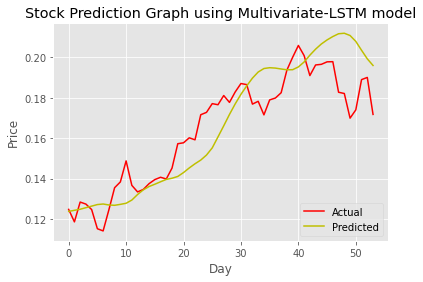

train_error  [0.09535002708435059, 0.04978775233030319, 0.05453125387430191, 0.03378305584192276, 0.026236360892653465, 0.023185212165117264, 0.016354896128177643, 0.01485641859471798, 0.014179935678839684, 0.013862141408026218, 0.013318255543708801, 0.012108034454286098, 0.012534726411104202, 0.013016513548791409, 0.011186265386641026, 0.008800989016890526, 0.009524018503725529, 0.008575030602514744, 0.00807804986834526, 0.007241759914904833, 0.007565867621451616, 0.0068705142475664616, 0.00616105692461133, 0.006211874540895224, 0.006032165605574846, 0.005770187824964523, 0.0055160559713840485, 0.005586293991655111, 0.0045623378828167915, 0.0039967261254787445, 0.00389535422436893, 0.003322086064144969, 0.0034226616844534874, 0.003009062958881259, 0.0029444291722029448, 0.002867545932531357, 0.003049634862691164, 0.0027483331505209208, 0.002721762517467141, 0.003194456221535802, 0.0029015224426984787, 0.002781034680083394, 0.002968749962747097, 0.002794681116938591, 0.0028057950548827

In [19]:
results = list()
cross_val_results = list()
n_split = 5
X = train

for t in timesteps:
  for l in hl:
      for rate in lr:
          for batch in batch_size:
              for epochs in num_epochs:
                for loss in loss:
                  for a in activation:
                    
                    train_loss = pd.DataFrame()
                    val_loss = pd.DataFrame()
                    train_loss_value = 0
                    val_loss_value = 0
                
                    for train_index,test_index in KFold(n_split).split(X):
                      #print(train_index,test_index)
                      x_train = X[train_index]
                      x_test = X[test_index]
                      #y_train,y_test=Y[train_index],Y[test_index]
                      model,train_error,val_error = fit_model(x_train,x_test,t,l,rate,batch,epochs,loss,a)
                      train_loss['fold'] = train_error
                      val_loss['fold'] = val_error
                      mse, rmse, r2_value,true,predicted = evaluate_model(model,test,t)
                      #print("Split 1", fold_no)
                      print('MSE = {}'.format(mse))
                      print('RMSE = {}'.format(rmse))
                      print('R-Squared Score = {}'.format(r2_value))
                      
                      plot_data(true,predicted)
                      cross_val_results.append([mse,rmse,r2_value,0])
                      #model,train_error,val_error = fit_model(x_train,x_test,timesteps,hl,lr,batch_size,num_epochs)
                      print('train_error ',train_error)
                      #model,train_loss,val_loss = fit_model(train,val,t,l,rate,batch,epochs)
                      train_loss_value = train_loss_value + train_loss.iloc[-1]['fold']
                      val_loss_value = val_loss_value + val_loss.iloc[-1]['fold']
                
                    results.append([t,l,rate,batch,epochs,loss,a,train_loss_value/n_split,val_loss_value/n_split])
                    print(results)                  

pd.DataFrame(results,columns=['Timestep','Hidden_Layers','Learning_Rate','Batch_Size','epochs','Loss','Activation','Train_Loss','Val_Loss']).to_csv('Multivariate-LSTM_model_Timesteps_0107.csv')
pd.DataFrame(cross_val_results,columns=['mse','rmse','r2_value','0']).to_csv('Multivariate-LSTM_model_Mse_0107.csv')

In [20]:
results

[[50,
  [40, 35],
  0.001,
  64,
  50,
  'mean_squared_error',
  'selu',
  0.0027933537494391203,
  0.004855274048168212]]

In [21]:
cross_val_results

[[0.00036981795339383614, 0.01923065140326339, 0.4692617805842795, 0],
 [0.00021994433815654182, 0.014830520495132388, 0.6843504612674715, 0],
 [0.00017875980713903688, 0.013370108718295333, 0.743455770945134, 0],
 [0.0004288843716055047, 0.020709523693351925, 0.38449357141207496, 0],
 [0.00021548183279135002, 0.01467929946527933, 0.6907547532438881, 0]]

In [22]:
timesteps = 50
hl = [60,55]
lr = 1e-3
batch = 64
epochs = 100
#optimizers = ['SGD', 'RMSprop', 'Adam']
loss = 'mean_squared_error'
activation = 'selu'

In [23]:
X_train = []
Y_train = []
X_val = []
Y_val = []
  
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)
  
# Loop for val data
for i in range(timesteps,test.shape[0]):
    X_val.append(test[i-timesteps:i])
    Y_val.append(test[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)
    
# Adding Layers to the model
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
# Adding LSTM layers and some Dropout regularisation
for i in range(len(hl)-1):        
  model.add(LSTM(hl[i], activation = activation,return_sequences = True))
  #model.add(Dropout(0.2))
model.add(LSTM(hl[-1],activation = activation))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
# Training the data
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
model.reset_states()
#model, history.history['loss'], history.history['val_loss']

Epoch 1/100
45/45 [==============================] - 44s 807ms/step - loss: 0.0740 - val_loss: 0.0112
Epoch 2/100
45/45 [==============================] - 37s 815ms/step - loss: 0.0364 - val_loss: 4.6338e-04
Epoch 3/100
45/45 [==============================] - 36s 811ms/step - loss: 0.0243 - val_loss: 5.2814e-04
Epoch 4/100
45/45 [==============================] - 35s 779ms/step - loss: 0.0146 - val_loss: 8.4418e-04
Epoch 5/100
45/45 [==============================] - 36s 808ms/step - loss: 0.0130 - val_loss: 3.9027e-04
Epoch 6/100
45/45 [==============================] - 36s 805ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 7/100
45/45 [==============================] - 37s 807ms/step - loss: 0.0084 - val_loss: 6.3944e-04
Epoch 8/100
45/45 [==============================] - 35s 790ms/step - loss: 0.0064 - val_loss: 7.0390e-04
Epoch 9/100
45/45 [==============================] - 34s 748ms/step - loss: 0.0058 - val_loss: 3.9629e-04
Epoch 10/100
45/45 [==============================] - 

MSE = 0.000162929149528402
RMSE = 0.012764370314606279
R-Squared Score = 0.7661748816733811


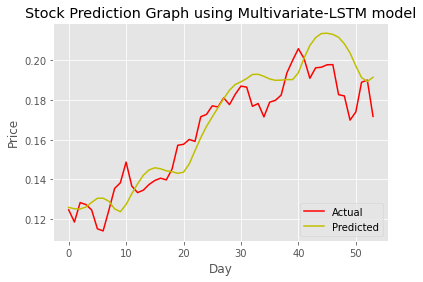

In [24]:
results = list()
cross_val_results = list()

mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)

print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
                      
plot_data(true,predicted)


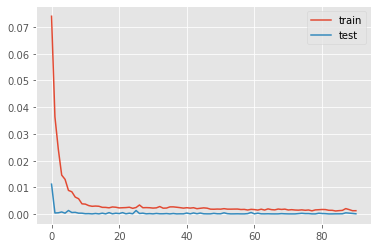

In [29]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
print(history.history['loss'])

[0.07399521768093109, 0.03639234974980354, 0.024307725951075554, 0.014625204727053642, 0.013019215315580368, 0.008901779539883137, 0.008385257795453072, 0.006409260910004377, 0.005785529967397451, 0.0038809047546237707, 0.0037761733401566744, 0.003218888072296977, 0.0029608902987092733, 0.003048960119485855, 0.0029727353248745203, 0.0025707115419209003, 0.002548615215346217, 0.0023921080864965916, 0.0027118653524667025, 0.0026100713293999434, 0.002355029806494713, 0.0024209655821323395, 0.0024769275914877653, 0.0026086182333528996, 0.002207761397585273, 0.0025109194684773684, 0.0034501494374126196, 0.002427524421364069, 0.002469317987561226, 0.0024214002769440413, 0.0022941825445741415, 0.0023734639398753643, 0.0028684271965175867, 0.002260980661958456, 0.002303691813722253, 0.0027369766030460596, 0.002745302626863122, 0.0026104587595909834, 0.002457226160913706, 0.0022749928757548332, 0.002425282495096326, 0.0022843764163553715, 0.0024271062575280666, 0.002064051339402795, 0.002225721

In [26]:
print(history.history['val_loss'])

[0.011235100217163563, 0.0004633758217096329, 0.0005281379562802613, 0.0008441818063147366, 0.0003902667958755046, 0.0013914124574512243, 0.0006394408992491663, 0.0007039029733277857, 0.0003962910268455744, 0.0003816882090177387, 0.0001977552310563624, 0.00022137706400826573, 0.00012086635251762345, 0.0002791309671010822, 0.00012463860912248492, 0.000389152584830299, 0.00013089561252854764, 0.0005912860506214201, 0.00015612661081831902, 0.00037327699828892946, 0.00024327084247488528, 0.0005924930446781218, 0.0001562270481372252, 0.00038686898187734187, 0.00016356745618395507, 0.0013816970167681575, 0.00027559546288102865, 0.00039664041833020747, 0.00014924128481652588, 0.0002282470086356625, 0.0001300874719163403, 0.0002909426111727953, 0.00016128561401274055, 0.00016421351756434888, 0.00024732164456509054, 0.00011564415763132274, 0.000269501528237015, 0.0001195942095364444, 0.00015071089728735387, 0.00014036450011190027, 0.00043741081026382744, 0.00014927779557183385, 0.00046845737961

In [28]:
model.save('DL_Project_LSTM_20220107')

INFO:tensorflow:Assets written to: DL_Project_LSTM_20220107/assets


INFO:tensorflow:Assets written to: DL_Project_LSTM_20220107/assets
